In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import constants

In [37]:
HEIGHT, WIDTH = 874, 1164

PP = (WIDTH // 2, HEIGHT // 2)
FOCAL_LENGTH = 910

In [38]:
img1 = cv2.imread("labeled/0/output_1000.png")
img2 = cv2.imread("labeled/0/output_1001.png")

torch.Size([3, 874, 1164])


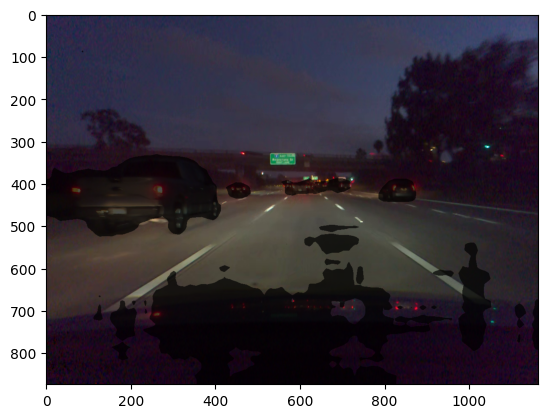

In [77]:
import torchvision
import torch
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torchvision.utils import draw_segmentation_masks

img = torch.from_numpy(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)).permute((2, 0, 1))
print(img.shape)

# Step 1: Initialize model with the best available weights
weights = FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
model = fcn_resnet50(weights=weights)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = preprocess(img).unsqueeze(0)

# Step 4: Use the model and visualize the prediction
prediction = torch.softmax(model(batch)["out"], dim=1)
prediction = torchvision.transforms.Resize((HEIGHT, WIDTH))(prediction)
class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}

IGNORE_CLASSES = ["motorbike", "car", "bus"]
ignore_class_probs = torch.index_select(prediction, dim=1, index=torch.LongTensor([class_to_idx[cl] for cl in IGNORE_CLASSES])).sum(1)[0]
mask = ignore_class_probs > 0.1
vis = draw_segmentation_masks(img, masks=mask, alpha=0.7)

plt.imshow(vis.permute((1, 2, 0)).numpy())

In [64]:
# detector = cv2.FastFeatureDetector_create(threshold=100, nonmaxSuppression=True)
# detector = cv2.ORB_create()
# detector = cv2.SIFT_create()

# p0 = np.array([x.pt for x in detector.detect(img1)], dtype=np.float32).reshape(-1, 1, 2)
# p0 = p0[p0[:, 0, 1] < 600]


p0 = cv2.goodFeaturesToTrack(
    cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY),
    maxCorners = 1000,
    qualityLevel = 0.01,
    minDistance = 20,
    blockSize = 5,
    mask=(~mask.numpy()).astype(np.uint8)
)


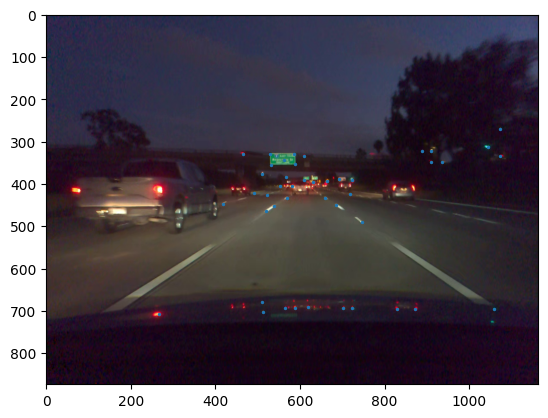

In [65]:
fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax.scatter(p0[:, 0, 0], p0[:, 0, 1], s=2)

In [66]:
p1, status, error = cv2.calcOpticalFlowPyrLK(
    prevImg=img1,
    nextImg=img2,
    prevPts=p0,
    nextPts=None, 
    winSize=(15, 15),
    maxLevel=2,
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
)

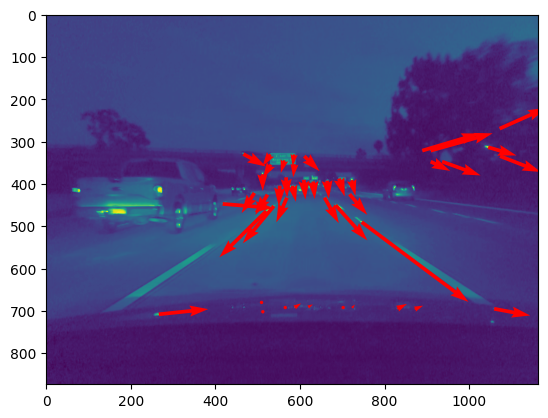

In [67]:
fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY))
diff = p1 - p0
ax.quiver(p0[:, 0, 0], p0[:, 0, 1], diff[:, 0, 0], diff[:, 0, 1], color="r", angles="xy", )

In [68]:
from monocular_slam import slam

R, t, points_3 = slam(p0, p1)

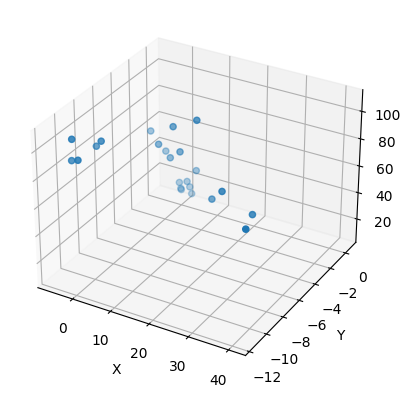

In [69]:
ax = plt.figure().add_subplot(111, projection="3d")
ax.scatter(points_3[:, 0], points_3[:, 1], points_3[:, 2])
ax.set(xlabel="X", ylabel="Y", zlabel="Z")
plt.show()

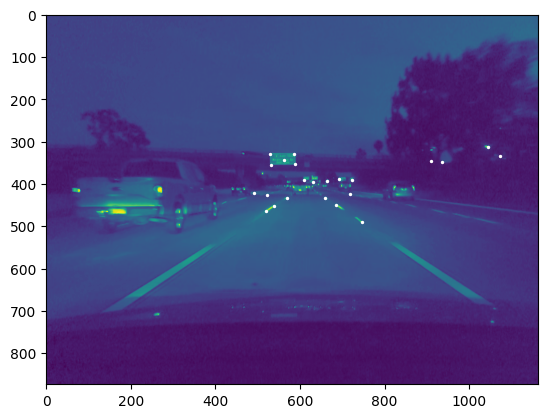

In [70]:
points_2d, _ = cv2.projectPoints(points_3, np.identity(3), np.zeros((3, 1)), cameraMatrix=constants.CAMERA_MAT, distCoeffs=None)
fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY))
ax.scatter(points_2d[:, 0, 0], points_2d[:, 0, 1], s=2, c="white")

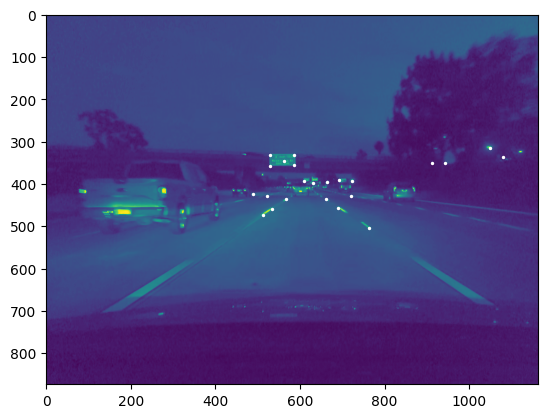

In [71]:
points_2d, _ = cv2.projectPoints(points_3, R, t, cameraMatrix=constants.CAMERA_MAT, distCoeffs=None)
fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY))
ax.scatter(points_2d[:, 0, 0], points_2d[:, 0, 1], s=2, c="white")

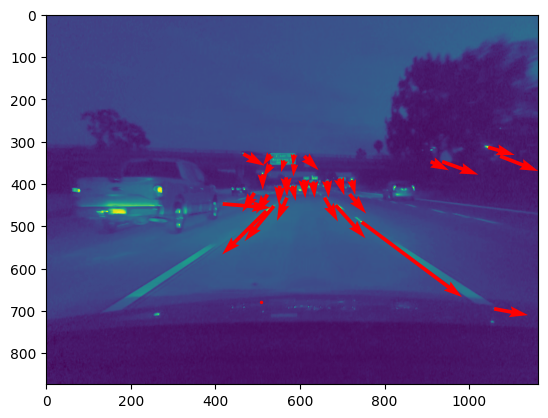

In [72]:
keep_towards = np.einsum("nik, k -> n", diff, np.array([0., 1.])) > 0.

fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY))
diff = p1 - p0
ax.quiver(p0[keep_towards, 0, 0], p0[keep_towards, 0, 1], diff[keep_towards, 0, 0], diff[keep_towards, 0, 1], color="r", angles="xy", )

In [14]:
valid_p0 = p0[status == 1]
valid_p1 = p1[status == 1]

R = np.zeros((3, 3), dtype=np.float64)
t = np.zeros((3, 3), dtype=np.float64)

E, _ = cv2.findEssentialMat(
    points1=valid_p0,
    points2=valid_p1,
    focal=FOCAL_LENGTH,
    pp=PP,
    method=cv2.RANSAC,
    prob=0.999,
    threshold=1.0,
    mask=None,
)

_, R, t, _ = cv2.recoverPose(
    E=E,
    points1=valid_p0,
    points2=valid_p1,
    R=R.copy(),
    t=t.copy(),
    focal=FOCAL_LENGTH,
    pp=PP,
    mask=None,
)

In [15]:
angles = np.arccos(t)

In [16]:
yaw = -(angles[2] - np.pi)
pitch = -(angles[1] - np.pi / 2)

yaw, pitch

(array([1.63469868]), array([0.581561]))

In [17]:
pitch_yaw_labels = np.loadtxt(f'labeled/0.txt')
shifts = np.tan(pitch_yaw_labels) * FOCAL_LENGTH

In [18]:
pitch_yaw_labels[0]

array([0.03346066, 0.03149205])

In [19]:
from monocular_slam import get_matches_orb
out = get_matches_orb(img1, img2)
print(out)

(array([[ 459.        ,  412.        ],
       [1043.        ,  315.        ],
       [ 265.20001221,  708.        ],
       ...,
       [ 397.13598633,  471.7855835 ],
       [ 400.61962891,  457.85098267],
       [ 658.08001709,  432.00003052]]), array([[ 461.        ,  416.        ],
       [1044.        ,  312.        ],
       [1041.        ,  313.        ],
       ...,
       [ 401.31637573,  472.98001099],
       [ 404.89953613,  458.64727783],
       [ 401.31637573,  437.14819336]]))
